In [ ]:
#Şevval Nur Özmen

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [2]:
import pandas as pd
from google.colab import files

uploaded = files.upload()


Saving Jobs_IT_Sub.csv to Jobs_IT_Sub.csv
Saving Jobs_Law_Sub.csv to Jobs_Law_Sub.csv
Saving Jobs_RD_Sub.csv to Jobs_RD_Sub.csv
Saving Jobs_Service_Sub.csv to Jobs_Service_Sub.csv
Saving Jobs_Strategy_Sub.csv to Jobs_Strategy_Sub.csv


In [3]:
csv_files = list(uploaded.keys())

dataframes = [pd.read_csv(file) for file in csv_files]

data = pd.concat(dataframes, ignore_index=True)

print(data.shape)
data.head()

(12500, 4)


,JobRefNo,DigerPozisyon,Qualifications,sub-classification
0,3464151,Bilgi Giriş Elemanı,<p>İlan metninizde yayına uygun olmayan bir ke...,Veri Girişi
1,3464150,Bilgi İşlem Asistanı Logo,"<p color=""""><strong>Lorem Ipsum</strong>&nbsp;...",Bilgi İşlem
2,3464145,Yazılım Destek Elemanı,<p>Yazılım Destek ElemanıYazılım Destek Eleman...,Yazılım Destek / Test
3,3464144,Yazılım Destek Elemanı,<p>Yazılım Destek ElemanıYazılım Destek Eleman...,Yazılım Destek / Test
4,3464133,Yazılım Geliştirme Mühendisi,<p>Aktif Satış Grup MüdürüAktif Satış Grup Müd...,Yazılım


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

### N-gram Vectorization ###
##N-gram vectorization is a common technique for text classification.
##This technique is used to convert text into vectors of numerical values.
def ngram_vectorize(train_texts, train_labels, val_texts, NGRAM_RANGE = (1, 2),TOP_K = 20000
                    ,TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2, vForm = 'tfidf'):
    """
    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams. <br>

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
        NGRAM_RANGE: The lower and upper boundary of the range of n-values for different n-grams to be extracted.
        TOP_K: The maximum number of features to be selected by SelectKBest.
        TOKEN_MODE: Whether text should be split into word or character n-grams.
        MIN_DOCUMENT_FREQUENCY: Minimum document/corpus frequency below which a token will be discarded.
        vForm: Vectorization form, either 'tfidf' or 'count'

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }

    if vForm == 'tfidf':
        vectorizer = TfidfVectorizer(**kwargs)
    elif vForm == 'count':
        vectorizer = CountVectorizer(**kwargs)
    else:
        print('Invalid vectorization form')
        return

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))#

    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val,vectorizer

In [5]:
# Nadir sınıfları çıkarma
min_count = 2  # Minimum örnek sayısı
class_counts = data['sub-classification'].value_counts()
valid_classes = class_counts[class_counts >= min_count].index
filtered_data = data[data['sub-classification'].isin(valid_classes)]

In [6]:
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(
    filtered_data['Qualifications'],  # Metin verisi
    filtered_data['sub-classification'],  # Hedef etiket
    filtered_data.index,  # Orijinal indeksleri korumak için
    test_size=0.1,  # Test setinin boyutu
    random_state=42,  # Sonuçların tekrarlanabilirliği için
    stratify=filtered_data['sub-classification']  # Sınıf dağılımını korumak için
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(11243,) (1250,) (11243,) (1250,)


In [7]:
# N-gram vektörizasyonunu uygulama
xtrain_tfv, xvalid_tfv, vectorizer = ngram_vectorize(
    x_train,  # Eğitim metinleri
    y_train,  # Eğitim etiketleri
    x_test,   # Test metinleri
    vForm='tfidf',  # Vektörizasyon biçimi
    NGRAM_RANGE=(1, 2),  # Unigram ve bigram kullan
    TOP_K=20000,  # Seçilecek maksimum özellik sayısı
    TOKEN_MODE='word',  # Kelime bazında tokenizasyon
    MIN_DOCUMENT_FREQUENCY=2  # Minimum belge sıklığı
)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2030: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [8]:
# Vektörlerin boyutlarını kontrol et
print("Eğitim Vektörlerinin Boyutu:", xtrain_tfv.shape)  # Eğitim verisi boyutu
print("Test Vektörlerinin Boyutu:", xvalid_tfv.shape)     # Test verisi boyutu

Eğitim Vektörlerinin Boyutu: (11243, 20000)
Test Vektörlerinin Boyutu: (1250, 20000)


In [9]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb  # XGBoost kütüphanesini içe aktarın

# Hedef etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Eğitim seti için
y_test_encoded = label_encoder.transform(y_test)  # Test seti için

# XGBoost modelini oluşturma ve eğitme
model = xgb.XGBClassifier()  # XGBoost modelini oluştur
model.fit(xtrain_tfv, y_train_encoded)  # Modeli eğit


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
# Test setinde tahmin yapma
predictions = model.predict(xvalid_tfv)
predictions_labels = label_encoder.inverse_transform(predictions)  # Sayısal tahminleri metin formatına çevir

In [11]:
# Gerçek etiketler ile tahmin edilen etiketleri karşılaştırma
comparison = pd.DataFrame({'Gerçek Etiketler': y_test_encoded, 'Tahmin Edilen Etiketler': predictions})
print(comparison.head(10))  # İlk 10 tahmini göster

   Gerçek Etiketler  Tahmin Edilen Etiketler
0                87                        0
1                 5                        5
2                 5                        5
3                 5                        5
4                55                       55
5                 5                        5
6                33                        7
7                88                       15
8                33                        7
9                77                       77


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Doğruluğu hesaplama
accuracy = accuracy_score(y_test_encoded, predictions)
print(f'Doğruluk: {accuracy:.2f}')

# Sınıflandırma raporu
report = classification_report(y_test_encoded, predictions)
print(report)

Doğruluk: 0.76
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        43
           1       0.00      0.00      0.00         0
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.84      0.92      0.88       238
           6       0.62      0.50      0.56        10
           7       0.87      0.97      0.92       173
           8       0.25      0.20      0.22         5
           9       0.70      0.74      0.72        43
          10       0.00      0.00      0.00         1
          12       0.40      0.40      0.40         5
          13       0.00      0.00      0.00         3
          14       0.82      0.67      0.73        27
          15       0.71      0.68      0.70        22
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          18

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [14]:
# Modeli oluşturma
model_logistic = LogisticRegression(max_iter=1000)  # max_iter, modelin iterasyon sayısını belirtir

# Modeli eğitme
model_logistic.fit(xtrain_tfv, y_train_encoded)

LogisticRegression(max_iter=1000)

In [15]:
# Test setinde tahmin yapma
predictions_logistic = model_logistic.predict(xvalid_tfv)

In [16]:
# Doğruluk oranını hesaplama
accuracy_logistic = accuracy_score(y_test_encoded, predictions_logistic)
print("Doğruluk:", accuracy_logistic)

# Detaylı rapor oluşturma
print(classification_report(y_test_encoded, predictions_logistic))

Doğruluk: 0.628
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        43
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.54      0.96      0.69       238
           6       1.00      0.10      0.18        10
           7       0.75      0.98      0.85       173
           8       0.00      0.00      0.00         5
           9       0.63      0.60      0.62        43
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       0.71      0.19      0.29        27
          15       0.60      0.68      0.64        22
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from sklearn.preprocessing import LabelEncoder

# Hedef etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Eğitim seti için
y_test_encoded = label_encoder.transform(y_test)  # Test seti için

# XGBoost modelini oluşturma ve eğitme
model = xgb.XGBClassifier()  # XGBoost modelini oluştur
model.fit(xtrain_tfv, y_train_encoded)  # Modeli eğit

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [33]:
# Test setinde tahmin yapma
xgb_predictions = xgb_model.predict(xvalid_tfv)

# Doğruluk oranını hesaplama
xgb_accuracy = accuracy_score(y_test_encoded, xgb_predictions)
print("XGBoost Doğruluk:", xgb_accuracy)

# Detaylı rapor oluşturma
print(classification_report(y_test_encoded, xgb_predictions))

XGBoost Doğruluk: 0.7624
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        43
           1       0.00      0.00      0.00         0
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.84      0.92      0.88       238
           6       0.62      0.50      0.56        10
           7       0.87      0.97      0.92       173
           8       0.25      0.20      0.22         5
           9       0.70      0.74      0.72        43
          10       0.00      0.00      0.00         1
          12       0.40      0.40      0.40         5
          13       0.00      0.00      0.00         3
          14       0.82      0.67      0.73        27
          15       0.71      0.68      0.70        22
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Doğruluğu hesaplama
accuracy = accuracy_score(y_test_encoded, predictions)
print(f'Doğruluk: {accuracy:.2f}')

# Sınıflandırma raporu
report = classification_report(y_test_encoded, predictions)
print(report)

Doğruluk: 0.76
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        43
           1       0.00      0.00      0.00         0
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.84      0.92      0.88       238
           6       0.62      0.50      0.56        10
           7       0.87      0.97      0.92       173
           8       0.25      0.20      0.22         5
           9       0.70      0.74      0.72        43
          10       0.00      0.00      0.00         1
          12       0.40      0.40      0.40         5
          13       0.00      0.00      0.00         3
          14       0.82      0.67      0.73        27
          15       0.71      0.68      0.70        22
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          18

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [19]:
from sklearn.model_selection import GridSearchCV

# Parametre ızgarası oluşturma
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Logistic Regression için düzenleme parametresi
    'max_iter': [100, 500, 1000]  # Iterasyon sayısı
}

# GridSearchCV nesnesini oluşturma
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=5)

# Modeli eğitme
grid_search.fit(xtrain_tfv, y_train_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 500, 1000]},
             scoring='accuracy')

In [20]:
# En iyi parametreleri yazdırma
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model ile tahmin yapma
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(xvalid_tfv)

# Doğruluk oranını hesaplama
best_accuracy = accuracy_score(y_test_encoded, best_predictions)
print("GridSearchCV ile En İyi Logistic Regression Doğruluk:", best_accuracy)

# Detaylı rapor oluşturma
print(classification_report(y_test_encoded, best_predictions))

En iyi parametreler: {'C': 10, 'max_iter': 100}
GridSearchCV ile En İyi Logistic Regression Doğruluk: 0.74
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        43
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.71      0.97      0.82       238
           6       0.67      0.20      0.31        10
           7       0.83      0.97      0.89       173
           8       0.00      0.00      0.00         5
           9       0.75      0.77      0.76        43
          10       0.00      0.00      0.00         1
          12       0.50      0.20      0.29         5
          13       0.00      0.00      0.00         3
          14       0.59      0.59      0.59        27
          15       0.77      0.77      0.77        22
          16       0.00      0.00      0.00         1
          17       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


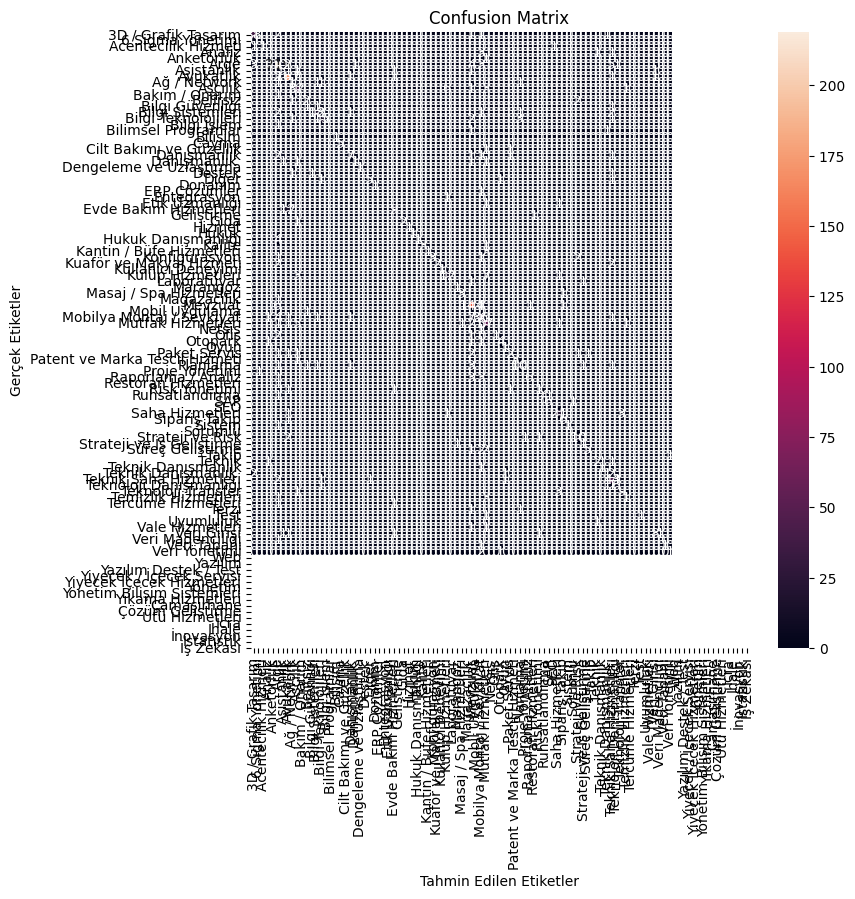

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix'i oluştur
conf_mat = confusion_matrix(y_test_encoded, label_encoder.transform(predictions_labels))

# Şekil ve eksen oluştur
fig, ax = plt.subplots(figsize=(8,8))

# Sınıf etiketlerini almak için benzersiz sınıflar
class_labels = label_encoder.classes_

# Isı haritasını çiz
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels)

# Ekseni etiketleme
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.title('Confusion Matrix')

# Grafiği göster
plt.show()


In [39]:
# İlk 40 örneği karşılaştırmadan önce, `inverse_transform` için verilerin uyumlu olduğundan emin olalım.
first_40_examples = pd.DataFrame({
    'Actual sub-classification': label_encoder.inverse_transform(y_test_encoded[:40]),  # Gerçek sub-classification
    'Predicted sub-classification': label_encoder.inverse_transform(lr_predictions[:40]),  # Tahmin edilen sub-classification
    'Text': x_test[:40]  # İlk 40 metin verisi
})

# İlk 40 örneği daha okunabilir şekilde görüntüleme
print("İlk 40 Örnek:")
display(first_40_examples)

NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [95]:
# Doğru ve yanlış sınıflandırmaların sayısını bulma
all_classified_examples['Correct'] = all_classified_examples['Actual sub-classification'] == all_classified_examples['Predicted sub-classification']

NameError: name 'all_classified_examples' is not defined

In [96]:
# Her bir sub-classification için genel tablo oluşturma
summary_table = all_classified_examples.groupby('Actual sub-classification').agg(
    Total=('Text', 'count'),
    Correct=('Correct', 'sum'),
    Incorrect=('Correct', lambda x: (~x).sum())
)

NameError: name 'all_classified_examples' is not defined

In [ ]:
#Genel tabloyu gösterme
print("Genel Sınıflandırma Sonuçları Tablosu:")
display(summary_table)

In [31]:
# Her sub-classification için ayrı tablo oluşturma
unique_labels = all_classified_examples['Actual sub-classification'].unique()

for label in unique_labels:
    filtered_examples = all_classified_examples[all_classified_examples['Actual sub-classification'] == label]
    print(f"Sınıflandırılan örnekler - Gerçek sub-classification: {label}")
    display(filtered_examples)
    print("\n")

NameError: name 'all_classified_examples' is not defined

In [ ]:
#hocam öncelikle verileri birleştirip vektörleştirip modelleri oluşturdum ancak en sondaki kısımlar hata veriyor.
#düzenlemeye çalıştım ancak her adım doğru olmasına rağmen hata devam ediyor